In [1]:
import os
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
btc = yf.download("BTC-USD", period="30d", interval="1d")

YF.download() has changed argument auto_adjust default to True



*********************100%***********************]  1 of 1 completed

In [3]:
btc.columns = [
    "_".join(map(str, col)).strip() if isinstance(col, tuple) else col
    for col in btc.columns.to_flat_index()
]


btc = btc.reset_index()

rename_map = {}
tickers = set()
for col in btc.columns:
    if col.lower() == "date":
        rename_map[col] = "date"
        continue

    parts = col.rsplit("_", 1)
    if len(parts) == 2:
        metric, ticker = parts
        rename_map[col] = metric.lower()
        tickers.add(ticker)
    else:
        rename_map[col] = col.lower()


btc = btc.rename(columns=rename_map)


if len(tickers) == 1:
    ticker = tickers.pop()
    btc["ticker"] = ticker
else:

    pass


cols = ["date", "ticker"] + [m for m in rename_map.values() if m not in ("date",)]
btc = btc[cols]


print(btc.columns.tolist())


['date', 'ticker', 'close', 'high', 'low', 'open', 'volume']


In [4]:
btc.head()

,date,ticker,close,high,low,open,volume
0,2025-03-25,BTC-USD,87471.703125,88542.398438,86346.078125,87512.820312,30005840049
1,2025-03-26,BTC-USD,86900.882812,88292.156250,85861.453125,87460.234375,26704046038
2,2025-03-27,BTC-USD,87177.101562,87786.726562,85837.937500,86896.257812,24413471941
3,2025-03-28,BTC-USD,84353.148438,87489.859375,83557.640625,87185.234375,34198619509
4,2025-03-29,BTC-USD,82597.585938,84567.335938,81634.140625,84352.070312,16969396135


In [5]:
btc.to_csv('data/btc_last30.csv', index=True)

In [6]:
btc = btc.drop(columns=['ticker'], errors='ignore')

symbol = "BTC-USD"
btc['ticker'] = symbol

btc['daily_return'] = btc['close'].pct_change()
btc['price_change'] = btc['close'] - btc['open']

btc.to_csv('data/btc_last30_with_metrics.csv', index=False)

btc[['date','ticker','open','close','daily_return','price_change']].head()



,date,ticker,open,close,daily_return,price_change
0,2025-03-25,BTC-USD,87512.820312,87471.703125,NaN,-41.117188
1,2025-03-26,BTC-USD,87460.234375,86900.882812,-0.006526,-559.351562
2,2025-03-27,BTC-USD,86896.257812,87177.101562,0.003179,280.843750
3,2025-03-28,BTC-USD,87185.234375,84353.148438,-0.032393,-2832.085938
4,2025-03-29,BTC-USD,84352.070312,82597.585938,-0.020812,-1754.484375


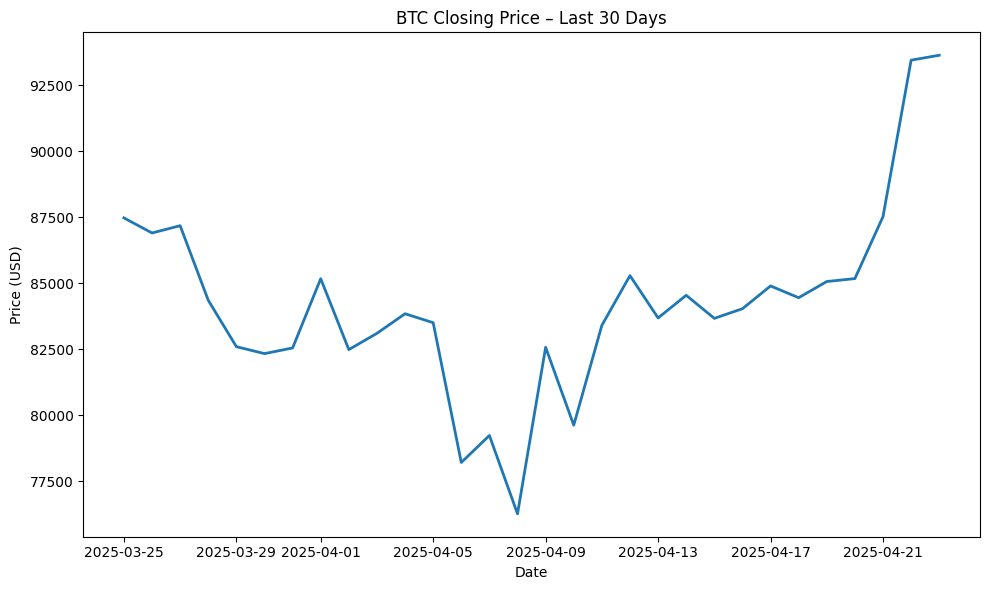

In [17]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(btc['date'], btc['close'], linewidth=2)
ax.set_title('BTC Closing Price – Last 30 Days')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
fig.tight_layout()

fig.savefig('outputs/btc_price_trend.png')
plt.show()
plt.close(fig)

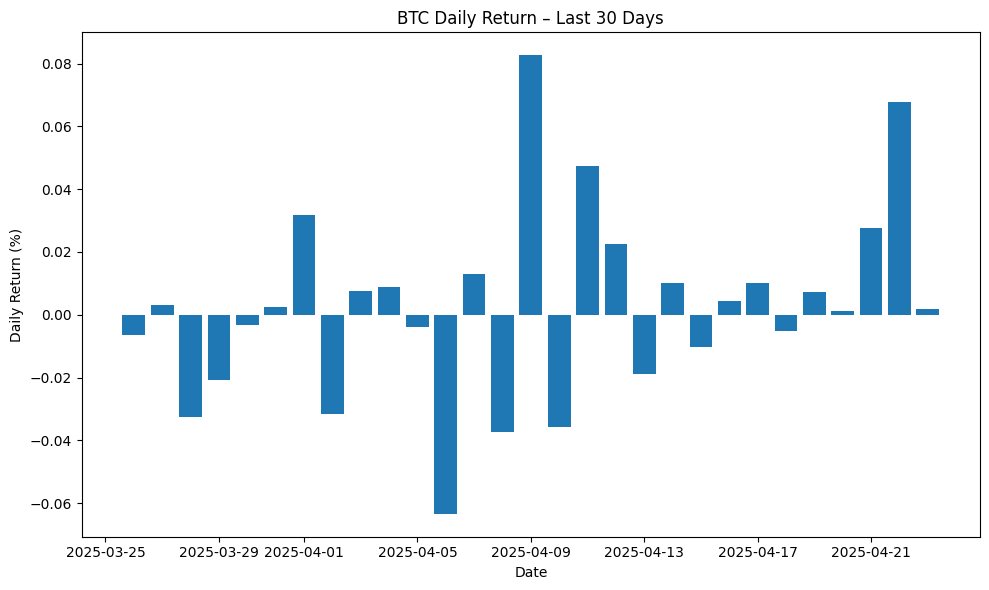

In [18]:
fig, ax = plt.subplots(figsize=(10,6))

ax.bar(btc['date'], btc['daily_return'])
ax.set_title('BTC Daily Return – Last 30 Days')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Return (%)')
fig.tight_layout()

fig.savefig('outputs/btc_daily_return.png')
plt.show()
plt.close(fig)

In [11]:
btc['sma_7']  = btc['close'].rolling(window=7).mean()
btc['sma_14'] = btc['close'].rolling(window=14).mean()

btc['trend'] = np.where(btc['sma_7'] > btc['sma_14'], 'Uptrend', 'Downtrend')

btc.to_csv('data/btc_with_trends.csv', index=False)

btc[['date','ticker','close','sma_7','sma_14','trend']].tail(14)


,date,ticker,close,sma_7,sma_14,trend
16,2025-04-10,BTC-USD,79626.140625,80467.209821,81847.310826,Downtrend
17,2025-04-11,BTC-USD,83404.835938,80404.500000,81779.574219,Downtrend
18,2025-04-12,BTC-USD,85287.109375,80659.116071,81971.683036,Downtrend
19,2025-04-13,BTC-USD,83684.976562,81440.614955,82068.143973,Downtrend
20,2025-04-14,BTC-USD,84542.390625,82198.765625,82210.535156,Downtrend
21,2025-04-15,BTC-USD,83668.992188,83255.485491,82103.379464,Uptrend
22,2025-04-16,BTC-USD,84033.867188,83464.044643,82213.962054,Uptrend
23,2025-04-17,BTC-USD,84895.750000,84216.845982,82342.027902,Uptrend
24,2025-04-18,BTC-USD,84450.804688,84366.270089,82385.385045,Uptrend
25,2025-04-19,BTC-USD,85063.414062,84334.313616,82496.714844,Uptrend


In [12]:
start_price = btc['close'].iloc[0]
end_price   = btc['close'].iloc[-1]
overall_return = ((end_price / start_price - 1) * 100).item()

In [13]:
current_trend = btc['trend'].iloc[-1]

In [14]:
message = (
    f"BTC 30-day return: {overall_return:.2f}% | "
    f"Current trend is: {current_trend}."
)
print(message)

BTC 30-day return: 7.04% | Current trend is: Uptrend.
